In [1]:
# library import
import os
 
import re
import random

import xml.etree.ElementTree as et
from PIL import Image
 
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
 
print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


In [3]:
!mkdir data

In [6]:
!unzip -q covid_mask_datasets.zip -d data

# ImageDataGenerator 생성

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 하이퍼파라미터, 변수 정의

In [8]:
LEARN_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 32

IMAGE_SIZE = 224

In [9]:
train_dir = "/content/data/New Masks Dataset/Train"
valid_dir = "/content/data/New Masks Dataset/Validation"
test_dir = "/content/data/New Masks Dataset/Test"

In [10]:
# ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [11]:
# raw data 연결
train_iter = train_datagen.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='binary', batch_size=N_BATCHS)

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                              class_mode='binary', batch_size=N_BATCHS)

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [12]:
# LABEL 확인 - Iterator.class_indices
train_iter.class_indices

{'Mask': 0, 'Non Mask': 1}

In [13]:
# 1 에폭당 step 수 - len(iterator)
len(train_iter), len(valid_iter), len(test_iter)

(19, 10, 4)

In [14]:
# iterator를 이용해서 데이터 조회
batch = next(train_iter) #batch_size 개수만큼 조회
print(type(batch)) #0: X-이미지데이터, 1: Y-label
print(type(batch[0]), type(batch[1]))
print(batch[0].shape, batch[1].shape)

<class 'tuple'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(32, 224, 224, 3) (32,)


In [15]:
batch[1][:10]

array([1., 0., 0., 0., 1., 1., 0., 0., 0., 1.], dtype=float32)

In [16]:
import numpy as np
np.min(batch[0][0]), np.max(batch[0][0])

(0.0, 1.0)

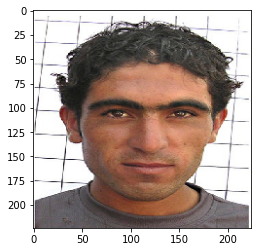

In [17]:
import matplotlib.pyplot as plt
plt.imshow(batch[0][0])
plt.show()

# Build network

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

import numpy as np

In [19]:
def create_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(layers.MaxPool2D(padding="same"))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    # Dense
    model.add(layers.Flatten())
    # dropout
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(units=512, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid')) #2진 분류 출력 레이어

    return model

In [20]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARN_RATE), 
              loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

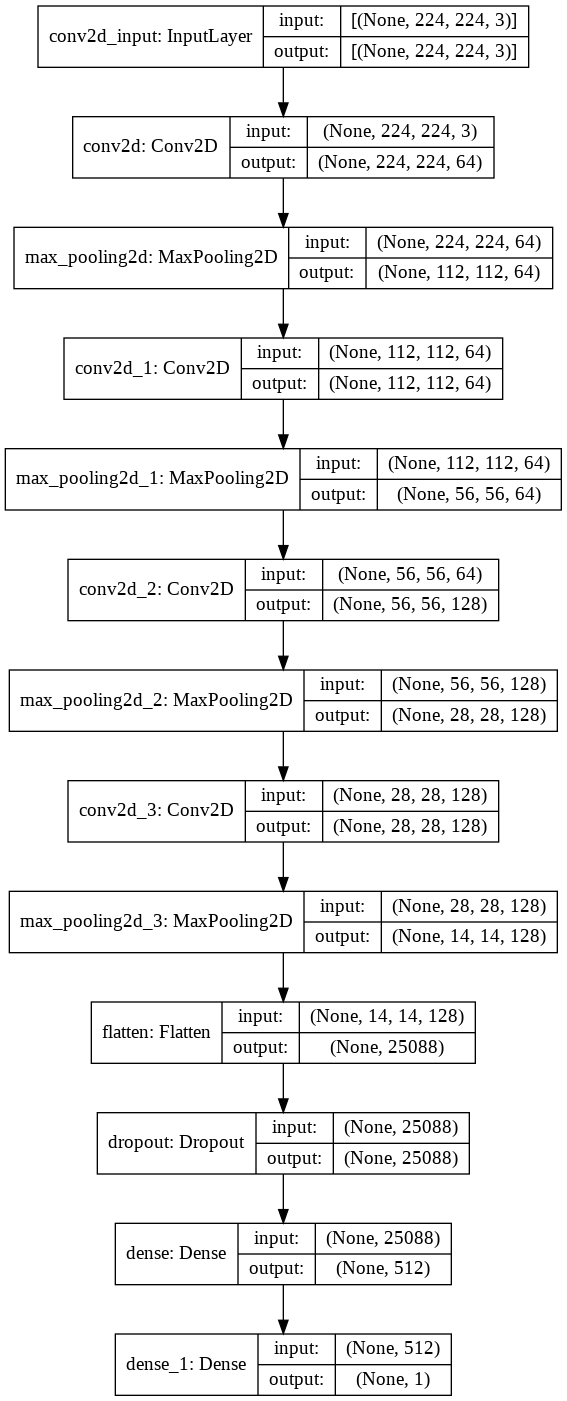

In [21]:
keras.utils.plot_model(model, show_shapes=True)

# Model training
- CNN 모델

In [5]:
import os
save_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks", "mask_model", "basic")
print(save_dir)
os.makedirs(save_dir, exist_ok=True)

/content/drive/MyDrive/Colab Notebooks/mask_model/basic


In [22]:
save_file_path = os.path.join(save_dir, "weights_ckpt")  #저장할 weight 파일경로

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True, 
                                              save_best_only=True, 
                                              monitor='val_loss', 
                                              verbose=2)

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            patience=10)

In [23]:
hist = model.fit(train_iter, epochs=N_EPOCHS, 
                 steps_per_epoch=len(train_iter),
                 validation_data=valid_iter, 
                 validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
19/19 [==============================] - 48s 754ms/step - loss: 0.7037 - accuracy: 0.6500 - val_loss: 0.5475 - val_accuracy: 0.6863

Epoch 00001: val_loss improved from inf to 0.54751, saving model to /content/drive/MyDrive/Colab Notebooks/mask_model/basic/weights_ckpt
Epoch 2/100
19/19 [==============================] - 12s 666ms/step - loss: 0.3768 - accuracy: 0.8367 - val_loss: 0.3745 - val_accuracy: 0.8529

Epoch 00002: val_loss improved from 0.54751 to 0.37454, saving model to /content/drive/MyDrive/Colab Notebooks/mask_model/basic/weights_ckpt
Epoch 3/100
19/19 [==============================] - 12s 665ms/step - loss: 0.3024 - accuracy: 0.8983 - val_loss: 0.3227 - val_accuracy: 0.8791

Epoch 00003: val_loss improved from 0.37454 to 0.32271, saving model to /content/drive/MyDrive/Colab Notebooks/mask_model/basic/weights_ckpt
Epoch 4/100
19/19 [==============================] - 12s 659ms/step - loss: 0.1861 - accuracy: 0.9333 - val_loss: 0.2617 - val_accuracy: 0.8987

E

- ResNet101V2

In [ ]:
# Hyper Parameters
LEARN_RATE = 0.0001
N_EPOCHS = 100
N_BATCH = 40
IMAGE_SIZE = 224

steps_per_epoch = N_TRAIN // N_BATCH   # 1 에폭 당 몇 번 학습(step 수)
validation_steps = int(np.ceil(N_VAL / N_BATCH))   # 1 에폭 당 몇 번 검증(step 수)

print(steps_per_epoch, validation_steps)

In [24]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow import keras

In [25]:
save_file_path = os.path.join(save_dir, "resnet", "weights_ckpt")
print(save_file_path)

/content/drive/MyDrive/Colab Notebooks/mask_model/basic/resnet/weights_ckpt


In [39]:
mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True, 
                                              save_best_only=True, 
                                              monitor='val_loss', 
                                              verbose=2)

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            patience=10)

In [40]:
def create_resnet_model():
    resnet101v2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    model = keras.models.Sequential()
    model.add(resnet101v2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [41]:
model = create_resnet_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)               

In [42]:
# 모델 컴파일
# learning rate scheduing - 10 에폭마다 0.5로 줄임
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARN_RATE,
                                                          decay_steps=len(train_iter)*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizers.Adam(lr_schedule), loss="mse", metrics=['accuracy'])

In [43]:
hist = model.fit(train_iter, epochs=N_EPOCHS, 
                 steps_per_epoch=len(train_iter),
                 validation_data=valid_iter, 
                 validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
19/19 [==============================] - 47s 2s/step - loss: 0.0622 - accuracy: 0.9183 - val_loss: 0.5000 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.50000, saving model to /content/drive/MyDrive/Colab Notebooks/mask_model/basic/resnet/weights_ckpt
Epoch 2/100
19/19 [==============================] - 32s 2s/step - loss: 0.0625 - accuracy: 0.9133 - val_loss: 0.4749 - val_accuracy: 0.4967

Epoch 00002: val_loss improved from 0.50000 to 0.47489, saving model to /content/drive/MyDrive/Colab Notebooks/mask_model/basic/resnet/weights_ckpt
Epoch 3/100
19/19 [==============================] - 28s 1s/step - loss: 0.0641 - accuracy: 0.9100 - val_loss: 0.5000 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.47489
Epoch 4/100
19/19 [==============================] - 28s 1s/step - loss: 0.0372 - accuracy: 0.9533 - val_loss: 0.5000 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.47489
Epoch 5/100
19/19 [===================

# 저장된 모델로 evaluate

In [45]:
saved_model = create_resnet_model()
saved_model.compile(optimizers.Adam(lr_schedule), loss="mse", metrics=['accuracy'])

# 저장된 weight를 불러오기
saved_model.load_weights(save_file_path)

In [46]:
saved_model.evaluate(test_iter)

4/4 [==============================] - 6s 586ms/step - loss: 0.0318 - accuracy: 0.9600


[0.03176001459360123, 0.9599999785423279]

In [47]:
model.evaluate(test_iter)

4/4 [==============================] - 2s 403ms/step - loss: 0.0319 - accuracy: 0.9600


[0.03192064166069031, 0.9599999785423279]